# Load and prepare data


In [1]:
# load and prepare data
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_2_regression_model/Exercise2BusData.csv'
df = pd.read_csv(url) #Bus data

In [2]:
df.head()

,Arrival_time,Stop_id,Bus_id,Line_id,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
0,01/05/2022 07:03,10033,41355,1,-23,0,39,-4,28.641509
1,01/05/2022 07:21,10033,41356,1,168,0,39,181,27.880597
2,01/05/2022 07:37,10033,44400,1,231,0,39,244,27.852941
3,01/05/2022 07:50,10033,44399,1,150,17,39,143,27.826087
4,01/05/2022 19:29,10033,44060,1,965,35,51,947,42.029412


<Axes: xlabel='Arrival_delay', ylabel='Count'>

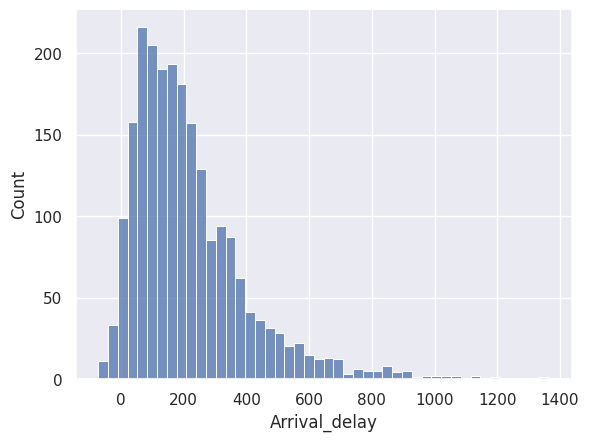

In [3]:
#Plot arrival delays at Linnégatan (seconds)
sns.histplot(x=df['Arrival_delay'])

How much does each of the attributes correlate with the delay time? We will use the attributes later to predict delays

In [4]:
df_dropped = df.drop(['Arrival_time'], axis=1) #Dropped arrival time because it's a string
corr_matrix = df_dropped.corr()
corr_matrix['Arrival_delay'].sort_values(ascending=False)

,Arrival_delay
Arrival_delay,1.000000
Upstream_stop_delay,0.993935
Dwell_time,0.218745
Recurrent_delay,0.162692
Scheduled_travel_time,0.100695
Bus_id,0.002019
Stop_id,NaN
Line_id,NaN


We see that Stop-id, Line_id is always the same. Bus_id has very little correlation. We will drop these values

In [5]:
df_dropped = df_dropped.drop(['Bus_id', 'Line_id', 'Stop_id'], axis=1)
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Arrival_delay          2179 non-null   int64  
 1   Dwell_time             2179 non-null   int64  
 2   Scheduled_travel_time  2179 non-null   int64  
 3   Upstream_stop_delay    2179 non-null   int64  
 4   Recurrent_delay        2179 non-null   float64
dtypes: float64(1), int64(4)
memory usage: 85.2 KB


# Plot data

We plot Arrival delays (y-axis) against the x-values (Dwell time, scheduled travel time, upstream stop delay and recurrent delay.

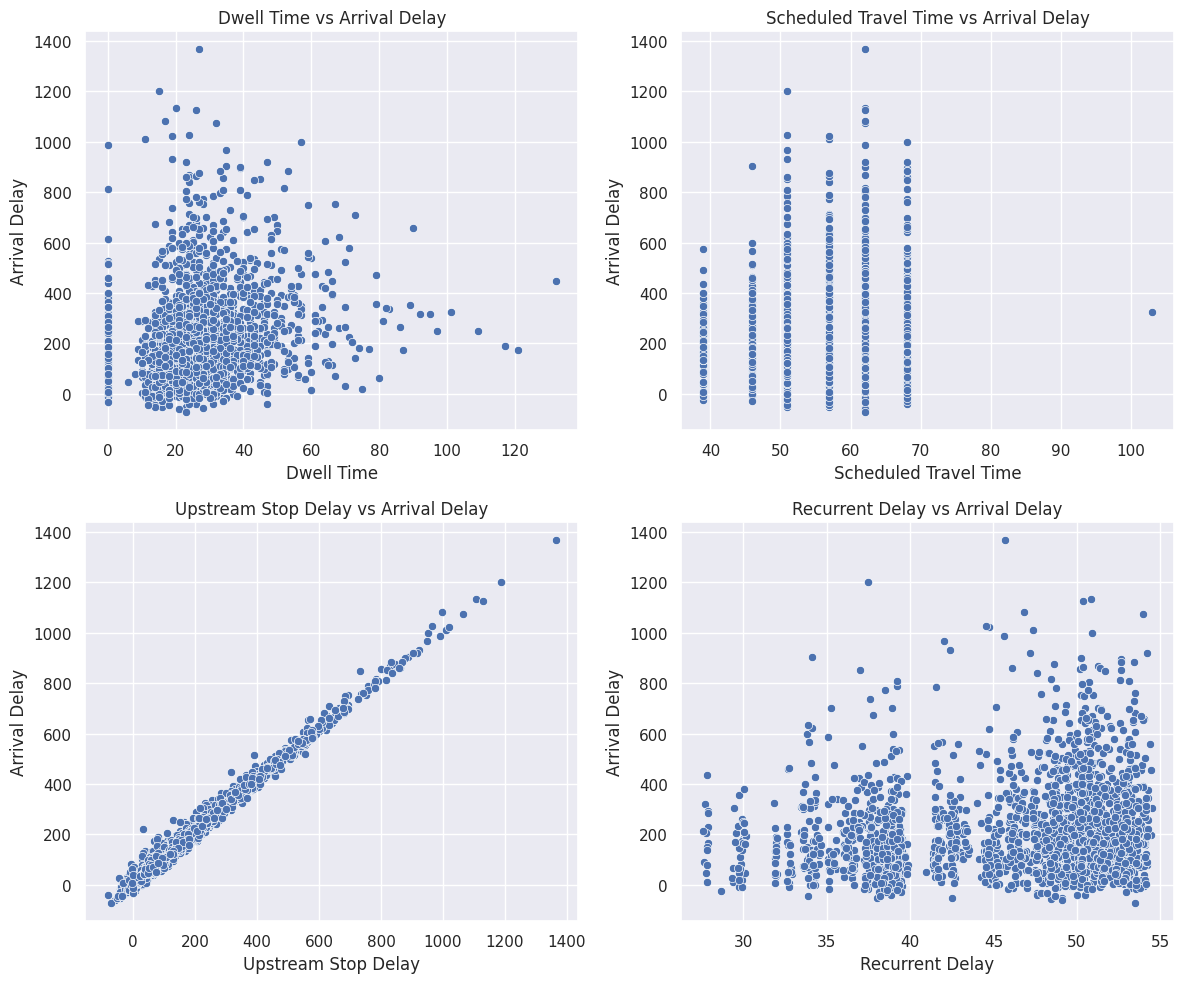

In [6]:
x = df_dropped.drop(['Arrival_delay'], axis=1)
y = df_dropped['Arrival_delay']


# List of column names and titles
columns = ['Dwell_time', 'Scheduled_travel_time', 'Upstream_stop_delay', 'Recurrent_delay']
titles = ['Dwell Time vs Arrival Delay', 'Scheduled Travel Time vs Arrival Delay', 'Upstream Stop Delay vs Arrival Delay', 'Recurrent Delay vs Arrival Delay']

# Set up subplots (2 rows, 2 columns)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Loop through each column and its corresponding title
for i, (col, title) in enumerate(zip(columns, titles)):
    # Determine row and column position in the 2x2 grid
    row = i // 2
    col_pos = i % 2

    # Select the data for the x-axis
    x_first_col = x.loc[:, col]

    # Plot using Seaborn
    sns.scatterplot(x=x_first_col, y=y, ax=axs[row, col_pos])

    # Set axis labels and title
    axs[row, col_pos].set_xlabel(col.replace('_', ' ').title())
    axs[row, col_pos].set_ylabel('Arrival Delay')
    axs[row, col_pos].set_title(title)

# Adjust layout
plt.tight_layout()
plt.show()

# Split data into trainng and testing sets

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [8]:
#Skalar om train data till [-1, 1] med medelvärde 0. Vi skippardock detta steg då det inte behövs med XGBoost
#from sklearn.preprocessing import StandardScaler

# Normalize the features
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

# Tune hyperparameters with Randomized Search and model with XGBoost

In [9]:
#Installera GBBoost
!pip install xgboost

In this model we will use Randomized search instead of grid search, and the Extreme Gradient Boost model

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

#Define XGBoost model
XGBmodel = XGBRegressor()

#Define hyperparameter grid with random values using RandomizedSearchCV
param_grid = { #We start by only using 3 hyperparameters
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2], #Slower rate is more accurate but learns slower
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4],

    'colsample_bytree': [0.7, 0.8, 1.0],  # Common parameter for XGBoost
    'reg_alpha': [0, 0.1, 0.5],           # L1 regularization term
    'reg_lambda': [1, 1.5, 2],            # L2 regularization term
}

#Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=XGBmodel,
    param_distributions=param_grid,
    n_iter=50, #Number of random parameter combinations to try
    cv=5, # Five fold cross-validation
    verbose=1, #How much information do you want in the output window
    random_state=42, #Always use same random state
)

#TRAIN MODEL: Fit RandomizedSearchCV to find the best hyperparameters
random_search.fit(X_train, y_train)

# Print the best hyperparameters and best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_
print("Best hyperparameters:", best_params, "\nBest model: ", best_model)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8} 
Best model:  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


Predict y values (arrival times) wih the new model, and calculate mean squared error compared to the test values

In [12]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


#Evaluae the model on the test data
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mse} \nMean Squared Error {mse} \nR2 Score  {r2}")

Mean Absolute Error: 214.02669515766033 
Mean Squared Error 214.02669515766033 
R2 Score  0.9928227031637539


# Vizualise the model

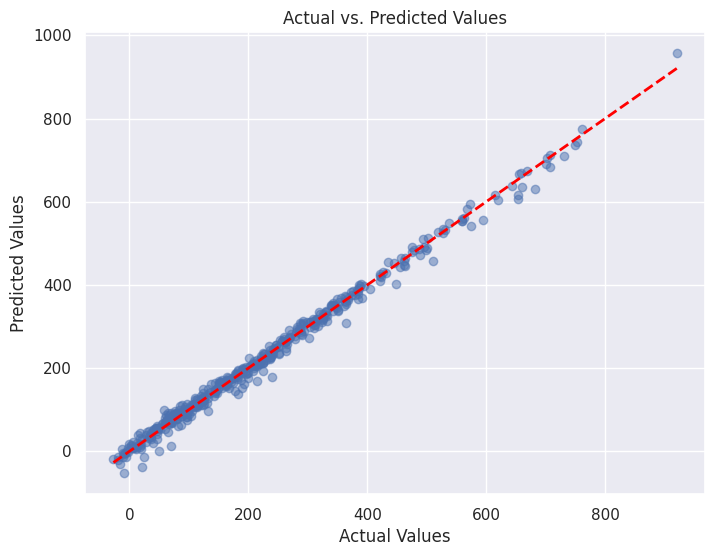

In [13]:
# y_test contains the actual target values for the test dataset
# y_pred contains the predicted values for the test dataset

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()